# Welcome to the SIMON-based cycloid cusp analysis code that accompanies Rhoden et al. (2021) in JGR Planets.
### There are several ways to use this notebook: 1) You can import the original data file and compute  intercusp and tail crack angles, 2) You can generate tidal stress output at the locations of the observed cycloid cusps for different parameter values, view orientation vs. stress curves, and interpolate to determine the failure stress implied by each cusp orientation, or 3) use the data files we generated that include both the observational data and tidal stress data in a modified format and analyze which cycloids are matched by the model. In this last case, we used interior structure 1 (see comments herein), and obliquity values of 0.25 and 0.50 degrees.

In [72]:
import pandas as pd
np = pd.np
import matplotlib.pyplot as plt
%pylab inline
from scipy.stats import norm

import StressEQs
StressEQs

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<module 'StressEQs' from '/Users/alyssa 1/StuffOnThisComputer/Research/PythonScriptsAndNotebooks/StressEQs.py'>

# 1. Import observation data
### Read in files, convert longitudes, create co-located clusters, compute intercusp/tailcrack angles

In [73]:
# REPLACE THIS PATH WITH THE LOCATION OF THE "CuspData_Public.csv" ON YOUR COMPUTER

obsFileCompleteDataSet = pd.read_csv('~/Desktop/CuspData_Public.csv')
obsFileCompleteDataSet[0:10]

,Cusp_ID,Id,Cycloid_Nu,Confidence,CompassA,DirMean,CirVar,AveX,AveY,AveLen,Lat_dd,Long_dd
0,1,1,1,1,1.138698e+02,336.130193,0,-4672598.945,1.237397e+06,20759.508500,45.386,8.614
1,1,1,1,1,3.572737e+02,92.726311,0,-4682785.423,1.244409e+06,4171.917871,45.644,8.240
2,2,2,1,1,6.273258e+01,152.732584,0,-4670283.836,1.238522e+06,16892.234400,45.428,8.699
3,2,2,1,1,7.000000e-15,90.000000,0,-4678055.987,1.245037e+06,3836.466006,45.667,8.414
4,3,1,2,1,1.270025e+02,322.997474,0,-4748043.710,1.135534e+06,18288.085570,41.650,5.847
5,3,1,2,1,6.613460e+00,83.386540,0,-4755134.558,1.145747e+06,7351.432981,42.025,5.587
6,4,1,3,1,1.477632e+02,302.236787,0,-4630568.475,9.547699e+05,27776.819870,35.020,10.156
7,4,1,3,1,6.894043e+01,21.059573,0,-4625223.881,9.721134e+05,24666.326360,35.656,10.352
8,5,1,4,1,1.384474e+02,311.552613,0,-4172706.101,1.326316e+06,31113.082290,48.648,26.950
9,5,1,4,1,2.622197e+01,63.778033,0,-4178923.822,1.349996e+06,19760.712840,49.516,26.722


In [8]:
obsFileCompleteDataSet['WestLon'] = (360 - obsFileCompleteDataSet['Long_dd'])%360   # Switch from -180 => 180 to 360 => 0

In [9]:
# Creating sub-groups of cycloids, based on cycloid number (Cycloid_Nu), which are co-located.

obsFile_cluster1 = obsFileCompleteDataSet[(obsFileCompleteDataSet['Cycloid_Nu'] >= 0) & (obsFileCompleteDataSet['Cycloid_Nu'] < 5)]
obsFile_cluster2 = obsFileCompleteDataSet[(obsFileCompleteDataSet['Cycloid_Nu'] >= 5) & (obsFileCompleteDataSet['Cycloid_Nu'] < 37)]
obsFile_cluster3 = obsFileCompleteDataSet[(obsFileCompleteDataSet['Cycloid_Nu'] >= 37) & (obsFileCompleteDataSet['Cycloid_Nu'] < 40)]
obsFile_cluster4 = obsFileCompleteDataSet[(obsFileCompleteDataSet['Cycloid_Nu'] >= 40) & (obsFileCompleteDataSet['Cycloid_Nu'] < 43)]
obsFile_cluster5 = obsFileCompleteDataSet[((obsFileCompleteDataSet['Cycloid_Nu'] >= 50) & (obsFileCompleteDataSet['Cycloid_Nu'] < 53)) | ((obsFileCompleteDataSet['Cycloid_Nu'] >= 43) & (obsFileCompleteDataSet['Cycloid_Nu'] < 48))]
obsFile_cluster6 = obsFileCompleteDataSet[(obsFileCompleteDataSet['Cycloid_Nu'] >= 53) & (obsFileCompleteDataSet['Cycloid_Nu'] < 65)]
obsFile_cluster7 = obsFileCompleteDataSet[((obsFileCompleteDataSet['Cycloid_Nu'] >= 65) & (obsFileCompleteDataSet['Cycloid_Nu'] < 87)) | ((obsFileCompleteDataSet['Cycloid_Nu'] >= 48) & (obsFileCompleteDataSet['Cycloid_Nu'] < 50))]
obsFile_cluster8 = obsFileCompleteDataSet[(obsFileCompleteDataSet['Cycloid_Nu'] >= 87) & (obsFileCompleteDataSet['Cycloid_Nu'] < 89)]

In [11]:
# Computing intercusp angles and corresponding tailcrack angles; can be modified to apply to individual clusters.

def intercusp(group):
    result = group['CompassA'].max() - group['CompassA'].min()
    if result > 180:
        result = 360.-result
    return result

cusps = pd.DataFrame()
cusps['IC_angle'] = obsFileCompleteDataSet.groupby(['Cusp_ID']).apply(intercusp)
cusps['TC_angle'] = 180.-cusps['IC_angle']


(array([ 0.,  4., 18., 37., 39., 67., 50., 21.,  6.,  1.,  2.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180.]),
 <a list of 18 Patch objects>)

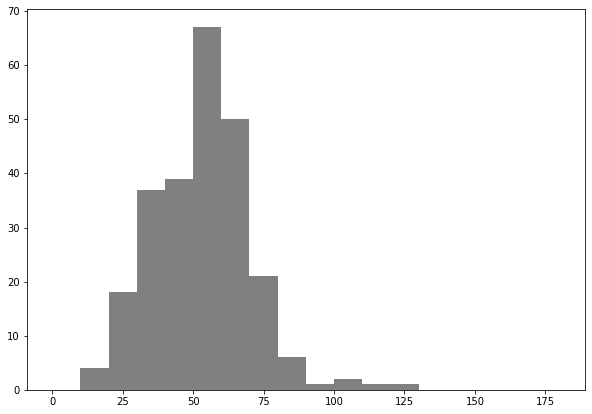

In [12]:
# Plotting histogram of tailcrack angles.

plt.figure(figsize=(10,7))
plt.hist(cusps['TC_angle'], color='grey', range=[0,180], bins = 18)

# 2. Get stress that results in each observed orientation
## Requires stress calculation code, StressEQs, which must be in the same folder as this notebook
### This portion of the code is shown for illustative purposes. These are the steps we used to compute interpolated stresses to match the observed cusp angles. However, in order to assess how many cycloids could be matched with a consistent propagation direction, we generated new data files that combine the observational data and the tidal stress predictions from these steps in a way that enables more straightforward assessment. Those data files are included with this package, and the anaylsis can be performed using the commands given later in this notebook (Section 3).

In [16]:
# For a list of observations, this function generates a data frame with the most tensile 
# tidal stress magntiude and predicted fracture orientation if failure occurred at that stress
# for each time step in the orbit. Inputs are given in the subsequent box.

def getStressCurves(data, thresh, latColName, eastlonColName, interior, ecc, steps, this_step, oblq, phase, NSRdelta):

    output = []
    
    for index, row in data.iterrows():
        thisStep = 0
        colat = radians(90. - row[latColName])
        lon = radians(row[eastlonColName])
        while thisStep < steps:
            stress = StressEQs.getStress(interior, ecc, colat, lon, steps, thisStep, radians(oblq), radians(phase), NSRdelta)
            thisStep += 1
        
            output.append({
                'stress': stress[0],
                'dir': degrees(stress[1]),
                'lonEast': row[eastlonColName],
                'lat': row[latColName],
                'obsDir': row['CompassA'],
                'cycNum': row['Cycloid_Nu'],
                'cuspID': row['Cusp_ID'],
                'cyc': index
            })
            
    outputDF = pd.DataFrame(output)

    return(outputDF)

In [18]:
int_val = 1         # Interior structure - 1 is the reference structure from Jara-Orue and Vermeersen, 2011; the other has a lower viscosity for the ductile ice shell 
ecc_val = 1111      # 1111 indicates the current eccentricity bookkept within the StressEQs file; currently set to 0.0094 for consistency with J&V2011
steps_val = 85      # Number of time steps per orbit; 85 produces one hour time steps
thisStep_val = 0    # Starting point in the orbit; no need to change for this investigation
oblqDeg_val = 0.25  # Obliquity in DEGREES
phaseDeg_val = 0    # Spin pole direction in DEGREES; see paper text for definition of angles
NSR_val = 0         # A non-dimensional metric for NSR period; best not to use here because the orientations are non-unique

thresh_val = 50      # Because we are interpolating, the failure threshold is not used

In [19]:
# To enable subsets of cycloids to be evaulated, we operate on a new data frame, dataSample, which 
# is a range of cycloid numbers. There are 88 cycloids in our total data set, so setting these limits
# form 0 to 90 ensures all cycloids are included.

dataSample = obsFileCompleteDataSet[(obsFileCompleteDataSet['Cycloid_Nu'] >= 0) & (obsFileCompleteDataSet['Cycloid_Nu'] < 90)]

# Gets stresses at all cusps along each cycloid within dataSample using parameters listed in preceeding box
outputCurves = getStressCurves(dataSample, thresh_val, 'Lat_dd', 'Long_dd', int_val, ecc_val, steps_val, thisStep_val, oblqDeg_val, phaseDeg_val, NSR_val)


In [20]:
# If desired, view the stress output file for a specific cycloid. Because there are two measurements for 
# each cusp, he number of rows will be equal to the 2 time the number of cusps along that cycloid times 
# 85 time steps per orbit. For cycloid number 4, there is only one cusp, so 170 rows.

currentCurve = outputCurves.loc[(outputCurves.cycNum == 4)]
display(currentCurve)

,cuspID,cyc,cycNum,dir,lat,lonEast,obsDir,stress
680,5.0,8,4.0,305.525582,48.648,26.950,138.447387,32.990727
681,5.0,8,4.0,302.578651,48.648,26.950,138.447387,34.571780
682,5.0,8,4.0,299.386836,48.648,26.950,138.447387,36.317088
683,5.0,8,4.0,295.968022,48.648,26.950,138.447387,38.258863
684,5.0,8,4.0,292.362805,48.648,26.950,138.447387,40.424399
685,5.0,8,4.0,288.634990,48.648,26.950,138.447387,42.830989
686,5.0,8,4.0,284.866036,48.648,26.950,138.447387,45.481191
687,5.0,8,4.0,281.143763,48.648,26.950,138.447387,48.359997
688,5.0,8,4.0,277.548790,48.648,26.950,138.447387,51.435010
689,5.0,8,4.0,274.143534,48.648,26.950,138.447387,54.659606


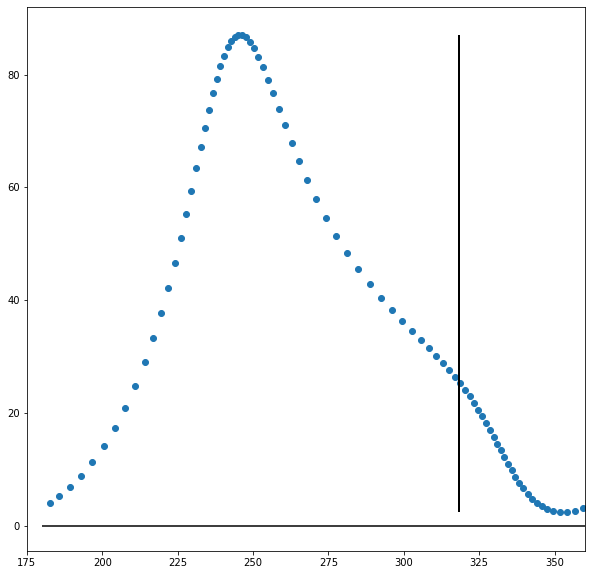

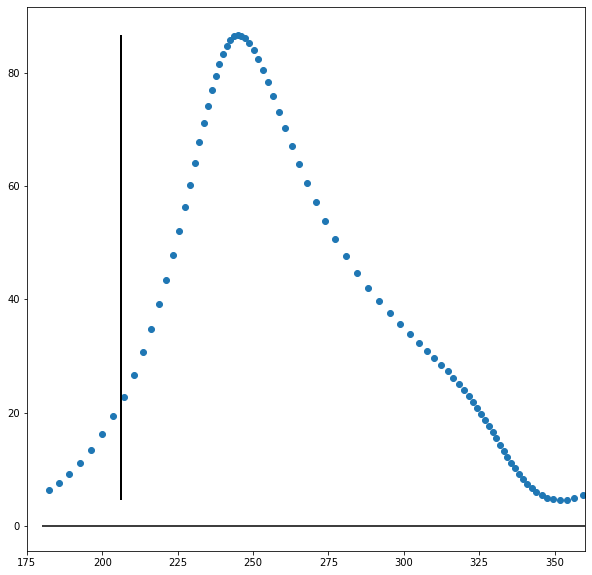

In [22]:
# If desired, plot direction vs. stress curves for each cusp of the specified cycloid. Two plots will be 
# produced for each cusp because each cusp has both a "left" and "right" measurement. The horizontal line 
# is at a stress of zero (tension > 0). The vertical line shows the orientation measured at the cusp.

currentCurve = outputCurves.loc[outputCurves.cycNum == 4]
for cusp in currentCurve.cyc.unique():
    currentCusp = currentCurve.loc[currentCurve.cyc == cusp]
    #print(cusp, currentCusp.obsDir)
    plt.figure(figsize=(10,10))
    plt.xlim(175,360)
    plt.vlines(currentCusp.obsDir, currentCusp.stress.min(), currentCusp.stress.max())
    plt.vlines(currentCusp.obsDir+180., currentCusp.stress.min(), currentCusp.stress.max())
    plt.hlines(0, 180, 360)
    plt.scatter(currentCusp.dir, currentCusp.stress)

In [25]:
# Identifying set of cusp measurements for which stress interpolation will be performed. If all cycloids are
# included the bounds will go from 0 to 493, for a total of 494 measurements.

min_cyc = outputCurves['cyc'].min()
max_cyc = outputCurves['cyc'].max()
print(min_cyc, max_cyc)

0 493


In [27]:
# Interpolating to identify the tidal stress value at which the observed orientation would be produced. The 
# slope of the stress is also computed. An observed orientation that occurs when the stress is decreasing is
# not considered a match.

interpStress = []
for count in range(min_cyc, max_cyc, 1):
    # For each cusp measurement, find the stress output for that measurement based on "obsDir", the measured 
    # direction at the cusp.
    interpVals = outputCurves.loc[outputCurves['cyc']==count]['obsDir']
    if interpVals.values[0] > 180.:   # changing orientations to match with predictions 
        interpVal = interpVals.values[0] - 180.
    else:
        interpVal = interpVals.values[0]
    plotDir = (outputCurves.loc[outputCurves['cyc']==count]['obsDir']).values[0]
    # The python interpolate function requires the curve to be increasing in the x-direction. 
    # By sorting the values such that stress or direction is increasing, we are simply rephasing them in time.
    tempDir = (outputCurves.loc[outputCurves['cyc']==count].sort_values('dir')['dir'])-180. 
    tempStress = outputCurves.loc[outputCurves['cyc']==count].sort_values('dir')['stress']
    tempLat = (outputCurves.loc[outputCurves['cyc']==count]['lat']).values[0]
    tempLon = (outputCurves.loc[outputCurves['cyc']==count]['lonEast']).values[0]
    
    stressDiff = np.diff(tempStress)
    dirDiff = np.diff(tempDir)

    slope = np.append(0, stressDiff / dirDiff)
    
    findStress = np.interp(interpVal,tempDir,tempStress)
    
    # direction -1 = decreasing, 0 = flat, 1 = increasing
    grad = np.interp(interpVal, tempDir, slope)
    if grad != 0:
        grad = -1 if grad < 0 else 1
    interpStress.append(
        {
            'stress': findStress,
            'grad': grad,
            'lonEast': tempLon,
            'lat': tempLat,
            'interpDir': interpVal,
            'obsDir': plotDir,
            'cyc': count
        }
    )

interpStress = pd.DataFrame(interpStress)


(array([ 8.,  7., 20., 13., 26., 30., 50., 30.,  9.,  7.]),
 array([  1.37789257,  11.44789376,  21.51789496,  31.58789615,
         41.65789734,  51.72789854,  61.79789973,  71.86790092,
         81.93790212,  92.00790331, 102.0779045 ]),
 <a list of 10 Patch objects>)

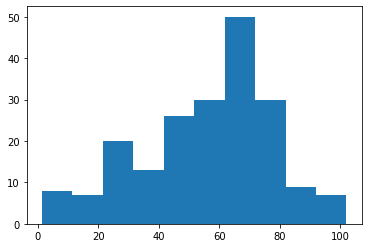

In [28]:
# Filter out only cusp orientations that can be matched with increasing, positive (tensile) stress
# and plot histogram of implied failure stresses

findStuff = interpStress[(interpStress['grad'] != -1) & (interpStress['stress'] > 0)]
plt.hist(findStuff['stress'])

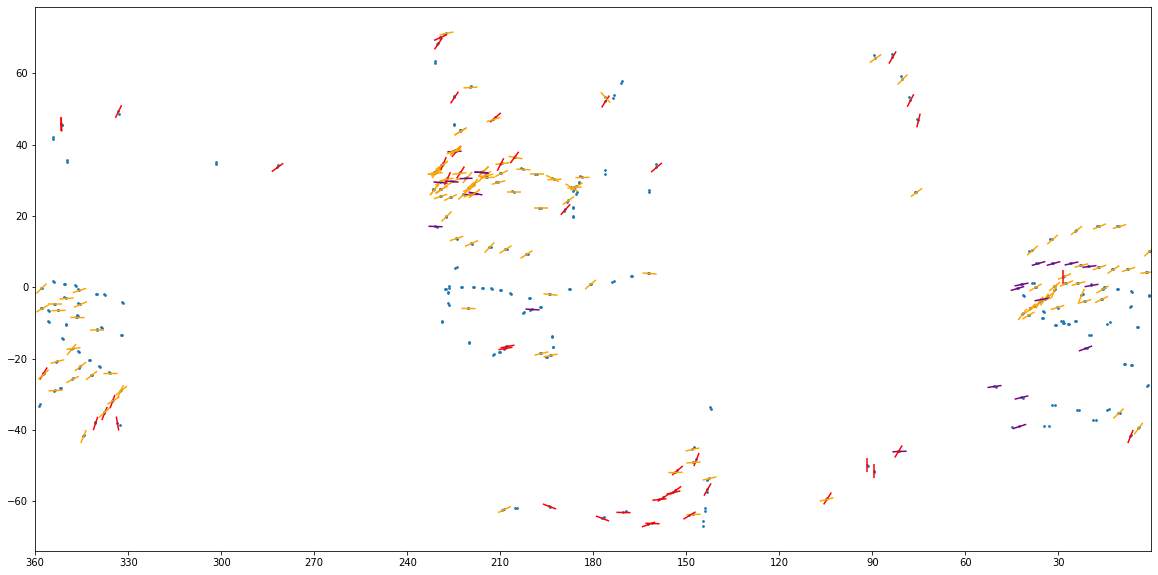

In [31]:
plt.figure(figsize=(20,10))
plt.xlim(360, 0)
plt.xticks(arange(360,0,-30))

# Plot locations of all cusps (blue dots)
plt.scatter(obsFileCompleteDataSet['WestLon'], obsFileCompleteDataSet['Lat_dd'], s=3)

# Plot lines with observed orientations, color based on implied stress magntiude at failure
for index, row in findStuff.iterrows():
    t = mpl.markers.MarkerStyle(marker='|')
    t._transform = t.get_transform().rotate_deg(360.0-row['obsDir'])
    if row['stress'] < 40:
        color_val = 'red'
    elif row['stress'] < 80:
        color_val = 'orange'
    else:
        color_val = 'purple'
    plt.scatter((360.-row['lonEast'])%360, row['lat'], marker=t, s=200, color=color_val)

# 3. Cycloid analysis with interpolated stress data files
## Interpolated stress with obliquity

In [70]:
# Interpolated stress output for obliquity values of 0.25 and 0.50 degrees, all phases in increments 
# of 30 degrees, reorganized such that all "left" and "right" measurements are columns while cusps are rows.

# REPLACE THIS PATH WITH THE LOCATION OF THE DATA FILE ON YOUR COMPUTER
oblqOutput = pd.read_csv("~/Desktop/interpolatedWithOblqStresses.csv.gz")

In [40]:
oblqOutput['percy'] = oblqOutput.stress/oblqOutput.max_stress
oblqOutput['check'] = 0
#display(oblqOutput.loc[oblqOutput.cycloid_number == 48])

In [41]:
# The tidal stress is a match to the observations if the stress associated with the observed orientation
# is either increasing or within 10% of the peak stress (so at least 90% of the peak stress)

def set_check(is_increasing, percy, stress):
    if is_increasing:
        return False if stress < 0 else True
    else:
        return True if percy > 0.9 else False


set_check_vect = np.vectorize(set_check)
oblqOutput['check'] = set_check_vect(oblqOutput.is_increasing,
                                           oblqOutput.percy,
                                           oblqOutput.stress)

In [42]:
leftOut = oblqOutput.loc[oblqOutput['cusp_direction'] == 'left']
rightOut = oblqOutput.loc[oblqOutput['cusp_direction'] == 'right']
outputNewFormat = pd.merge(leftOut, rightOut, on=['cusp_id', 'phase', 'obliquity'])

In [43]:
# Summary data frame shows independent checks of the "left" and "right" sides of each cusp

output_summary = outputNewFormat[['Id_x','cusp_id','cycloid_number_x','orientation_original_x','orientation_original_y',
                                  'stress_x','stress_y','percy_x','percy_y',
                                  'check_x','check_y', 'phase',
                                  'obliquity']].copy()
output_summary.columns = ['id','cusp_id','cyc_num','dir_left','dir_right','stress_left','stress_right',
                          'percy_left','percy_right','check_left','check_right', 
                          'phase', 'obliquity']

In [44]:
display(output_summary[0:10])

,id,cusp_id,cyc_num,dir_left,dir_right,stress_left,stress_right,percy_left,percy_right,check_left,check_right,phase,obliquity
0,1,1,1,113.869807,3.572737e+02,40.999223,2.574505,0.538307,0.033962,False,True,0,0.25
1,2,2,1,62.732584,7.000000e-15,68.732339,3.429440,0.901340,0.045132,True,True,0,0.25
2,1,4,2,127.002527,6.613460e+00,38.341354,-2.350650,0.526594,-0.032403,False,False,0,0.25
3,1,6,3,147.763213,6.894043e+01,-10.956785,71.036141,-0.140295,0.907742,False,True,0,0.25
4,1,7,4,138.447387,2.622197e+01,27.504319,23.593283,0.299717,0.258119,False,True,0,0.25
5,1,8,5,103.928342,3.500958e+02,69.236743,1.736186,0.949780,0.023998,True,True,0,0.25
6,1,9,6,202.932100,5.463754e+01,41.402858,46.185099,0.710130,0.786348,True,False,0,0.25
7,2,10,6,198.434949,4.989909e+01,31.018678,47.241090,0.480927,0.729490,True,True,0,0.25
8,3,11,6,202.166346,4.772631e+01,37.477627,48.423790,0.539430,0.692765,True,True,0,0.25
9,4,12,6,199.798876,5.857043e+01,34.283472,53.700336,0.457330,0.713068,True,True,0,0.25


In [45]:
cuspCheck = output_summary.groupby(['cyc_num', 'phase', 'obliquity'])

In [49]:
display(output_summary.loc[(output_summary.cyc_num == 3) & (output_summary.obliquity == 0.25)])

,id,cusp_id,cyc_num,dir_left,dir_right,stress_left,stress_right,percy_left,percy_right,check_left,check_right,phase,obliquity
3,1,6,3,147.763213,68.940427,-10.956785,71.036141,-0.140295,0.907742,False,True,0,0.25
250,1,6,3,147.763213,68.940427,-14.499311,72.657509,-0.182251,0.912962,False,True,30,0.25
497,1,6,3,147.763213,68.940427,-7.599532,73.025960,-0.097445,0.937688,False,True,60,0.25
744,1,6,3,147.763213,68.940427,15.053957,71.842700,0.203678,0.975008,False,True,90,0.25
991,1,6,3,147.763213,68.940427,40.026204,68.010890,0.585579,0.999554,False,True,120,0.25
1238,1,6,3,147.763213,68.940427,49.959230,61.411693,0.798322,0.987033,False,True,150,0.25
1485,1,6,3,147.763213,68.940427,49.098987,55.730193,0.849491,0.970233,False,True,180,0.25
1732,1,6,3,147.763213,68.940427,42.655276,54.080621,0.772210,0.983781,False,True,210,0.25
1979,1,6,3,147.763213,68.940427,32.962362,56.039772,0.587312,0.999900,False,True,240,0.25
2226,1,6,3,147.763213,68.940427,21.418208,59.930670,0.352945,0.985492,False,True,270,0.25


In [51]:
# Function determines whether all cusps along a cycloid can be matched on the same side 
# (e.g. all "right" side measurements match), to ensure a consistent propagation direction 
# is being applied to all cusps

def finalAnswer(data):
    count = 0
    if data['check_left'].all():
        count += 1
    elif data['check_right'].all():
        count += 1
    return count



In [53]:
# Determines number of cycloids for which all cusps can be matched with a consistent propagation direction, 
# for each combination of obliquity value and spin pole direction (phase).

answer = cuspCheck.apply(finalAnswer)

df = pd.DataFrame(answer).stack().reset_index()
df[['cyc_num', 'phase', 'obliquity', 0]].groupby(['phase', 'obliquity']).sum()

cyc_num   0
phase obliquity             
0     0.25          3864  53
      0.50          3864  50
30    0.25          3864  48
      0.50          3864  44
60    0.25          3864  53
      0.50          3864  50
90    0.25          3864  57
      0.50          3864  65
120   0.25          3864  57
      0.50          3864  67
150   0.25          3864  57
      0.50          3864  65
180   0.25          3864  52
      0.50          3864  53
210   0.25          3864  52
      0.50          3864  49
240   0.25          3864  58
      0.50          3864  59
270   0.25          3864  58
      0.50          3864  54
300   0.25          3864  59
      0.50          3864  49
330   0.25          3864  56
      0.50          3864  48

In [54]:
# Lists whether a cycloid (1 through 89) is matched by the "left" or "right" measurements along ALL of its
# cusps. If one or more cusps cannot be matched on either side, "none" is shown instead. Results are listed 
# for each obliquity value and phase.

def who_fit(data):
    all_left = data.check_left.all()
    all_right = data.check_right.all()
    
    if all_left and not all_right:
        return 'left'
    if not all_left and all_right:
        return 'right'
    if all_left and all_right:
        left_stress = data.percy_left.mean()
        right_stress = data.percy_right.mean()
        if left_stress > right_stress:
            return 'left'
        else:
            return 'right'
    
    return 'none'

result = cuspCheck.apply(who_fit)
result[0:10]

cyc_num  phase  obliquity
1        0      0.25         right
                0.50          none
         30     0.25          none
                0.50          none
         60     0.25          left
                0.50          none
         90     0.25          left
                0.50          left
         120    0.25          left
                0.50          left
dtype: object

In [55]:
# Obtains the inferred failure stress for each matched cycloid, based on which side enabled the match.

df = pd.DataFrame(result, columns=['side'])
output_summary_merged = pd.merge(output_summary, df, 
                                 left_on=['cyc_num', 'phase', 'obliquity'], 
                                 right_index=True)

matched = output_summary_merged.loc[output_summary_merged.side != 'none'].copy()

def find_plot_stress(left_stress, right_stress, side):
    if side == 'left':
        return left_stress
    else:
        return right_stress

def find_plot_percy(percy_left, percy_right, side):
    if side == 'left':
        return percy_left
    else:
        return percy_right
    
def find_plot_dir(dir_left, dir_right, side):
    if side == 'left':
        return dir_left
    else:
        return dir_right
    
fps = np.vectorize(find_plot_stress)
matched['plot_stress'] = fps(matched['stress_left'],
                              matched['stress_right'],
                              matched['side'])
fpp = np.vectorize(find_plot_percy)
matched['plot_percy'] = fps(matched['percy_left'],
                              matched['percy_right'],
                              matched['side'])
fpd = np.vectorize(find_plot_dir)
matched['plot_dir'] = fpd(matched['dir_left'],
                              matched['dir_right'],
                              matched['side'])

In [56]:
# Pulls out results for obliquity of 0.25 degrees and splits up spin pole directions 

phase0 = matched.loc[(matched.obliquity==0.25) & (matched.phase==0)].copy()
phase30 = matched.loc[(matched.obliquity==0.25) & (matched.phase==30)].copy()
phase60 = matched.loc[(matched.obliquity==0.25) & (matched.phase==60)].copy()
phase90 = matched.loc[(matched.obliquity==0.25) & (matched.phase==90)].copy()
phase120 = matched.loc[(matched.obliquity==0.25) & (matched.phase==120)].copy()
phase150 = matched.loc[(matched.obliquity==0.25) & (matched.phase==150)].copy()
phase180 = matched.loc[(matched.obliquity==0.25) & (matched.phase==180)].copy()
phase210 = matched.loc[(matched.obliquity==0.25) & (matched.phase==210)].copy()
phase240 = matched.loc[(matched.obliquity==0.25) & (matched.phase==240)].copy()
phase270 = matched.loc[(matched.obliquity==0.25) & (matched.phase==270)].copy()
phase300 = matched.loc[(matched.obliquity==0.25) & (matched.phase==300)].copy()
phase330 = matched.loc[(matched.obliquity==0.25) & (matched.phase==330)].copy()


In [57]:
# Determines cycloid (by cycloid number) that cannot be fit at any spin pole direction with an obliquity of 0.25

phaseTest = matched.loc[(matched.obliquity==0.25)].copy()
all_cusps = set(arange(1,89,1))
out_allPhases = set(phaseTest.cyc_num.unique())
print(all_cusps-out_allPhases)
print(len(all_cusps-out_allPhases))
print(len(out_allPhases))

{7, 44, 13, 60, 77, 79, 51, 52, 53, 86, 23, 24, 28, 61}
14
74


## Interpolated stress w/out obliquity

### Same methodology as above, but simplified due to zero obliquity. See comments in previous section for explanation of steps.

In [74]:
# REPLACE THIS PATH WITH THE LOCATION OF THE DATA FILE ON YOUR COMPUTER

output_noO = pd.read_csv("~/Desktop/interpolatedStress.csv.gz") 
output_noO['percy'] = output_noO.stress/output_noO.max_stress
output_noO['check'] = 0

In [75]:
def set_check(is_increasing, percy, stress):
    if is_increasing:
        return False if stress < 0 else True
    else:
        return True if percy > 0.9 else False


set_check_vect = np.vectorize(set_check)
output_noO['check'] = set_check_vect(output_noO.is_increasing,
                                           output_noO.percy,
                                           output_noO.stress)

In [76]:
leftOut_noO = output_noO.loc[output_noO['cusp_direction'] == 'left']
rightOut_noO = output_noO.loc[output_noO['cusp_direction'] == 'right']
outputNewFormat_noO = pd.merge(leftOut_noO, rightOut_noO, on=['cusp_id'])
# display(outputNewFormat_noO[0:10])

In [77]:
output_summary_noO = outputNewFormat_noO[['cusp_id','cycloid_number_x','orientation_original_x','orientation_original_y',
                                  'stress_x','stress_y','percy_x','percy_y',
                                  'check_x','check_y']].copy()
output_summary_noO.columns = ['cusp_id','cyc_num','dir_left','dir_right','stress_left','stress_right',
                          'percy_left','percy_right','check_left','check_right']



In [78]:
cuspCheck_noO = output_summary_noO.groupby(['cyc_num'])

In [79]:
answer = cuspCheck_noO.apply(finalAnswer)
print(answer.sum())

51


In [80]:
result_noO = cuspCheck_noO.apply(who_fit)
result_noO[0:10]

cyc_num
1      left
2      none
3     right
4     right
5      left
6     right
7      none
8      left
9      none
10     left
dtype: object

In [81]:
df_noO = pd.DataFrame(result_noO, columns=['side'])
output_summary_merged_noO = pd.merge(output_summary_noO, df_noO, 
                                 left_on=['cyc_num'], 
                                 right_index=True)

matched_noO = output_summary_merged_noO.loc[output_summary_merged_noO.side != 'none'].copy()
display(matched_noO)

,cusp_id,cyc_num,dir_left,dir_right,stress_left,stress_right,percy_left,percy_right,check_left,check_right,side
0,1,1,113.869807,3.572737e+02,43.271420,9.057118,0.702952,0.148143,True,False,left
1,2,1,62.732584,7.000000e-15,60.804833,8.865519,0.986411,0.144578,True,False,left
3,6,3,147.763213,6.894043e+01,19.666719,65.720776,0.295822,0.989909,False,True,right
4,7,4,138.447387,2.622197e+01,32.407574,27.789393,0.409222,0.352574,False,True,right
5,8,5,103.928342,3.500958e+02,83.084137,-10.272870,0.999540,-0.124425,True,False,left
6,9,6,202.932100,5.463754e+01,15.701831,43.991343,0.224924,0.626888,True,True,right
7,10,6,198.434949,4.989909e+01,3.927633,45.316180,0.052248,0.601057,True,True,right
8,11,6,202.166346,4.772631e+01,11.564160,47.299939,0.145609,0.592967,True,True,right
9,12,6,199.798876,5.857043e+01,7.593093,55.274444,0.090374,0.655694,True,True,right
10,13,6,204.775141,5.114663e+01,29.602111,55.702528,0.336330,0.629575,True,True,right


In [82]:
all_cusps = set(arange(1,89,1))
out_noO = set(matched_noO.cyc_num.unique())
print(all_cusps-out_noO)

print(len(all_cusps-out_noO))

{2, 7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 33, 34, 43, 44, 48, 49, 51, 52, 53, 55, 56, 57, 59, 60, 61, 63, 64, 77, 79, 86}
37
